# Generalized Space-Time Autoregressive (GSTAR) pada Data Suhu Rata-rata di Surabaya

* **Yolla Faradhilla** (05111950010029)
* **Hafara Firdausi** (05111950010040)

## Dataset
Dataset didapatkan dari http://dataonline.bmkg.go.id/, yaitu data suhu rata-rata pada tanggal 1 Januari 2019 hingga 12 Mei 2020 dari stasiun meteorologi Perak I, Perak II, dan Juanda

## 1. Load and Prepare Data

In [1]:
library(xlsx)
library(Metrics)
library(ggplot2)
library(gstar)

In [2]:
data <- read.xlsx(("data-temperature-2019-2020.xlsx"),1, header=TRUE)
head(data)
tail(data)

,Tanggal,Perak.I,Perak.II,Juanda
,<fct>,<dbl>,<dbl>,<dbl>
1,01-01-2019,28.9,29.5,29.0
2,02-01-2019,29.0,29.2,28.5
3,03-01-2019,27.3,27.2,25.6
4,04-01-2019,27.7,28.0,27.6
5,05-01-2019,29.1,29.7,29.2
6,06-01-2019,30.4,30.4,28.9


,Tanggal,Perak.I,Perak.II,Juanda
,<fct>,<dbl>,<dbl>,<dbl>
523,07-05-2020,29.9,30.0,28.5
524,08-05-2020,30.6,30.3,29.5
525,09-05-2020,29.0,29.1,28.7
526,10-05-2020,29.4,29.3,29.0
527,11-05-2020,29.1,28.9,27.9
528,12-05-2020,29.8,29.5,NA


In [3]:
nrow(data)

[1] 528

In [4]:
data$Tanggal <- NULL
head(data)

,Perak.I,Perak.II,Juanda
,<dbl>,<dbl>,<dbl>
1,28.9,29.5,29.0
2,29.0,29.2,28.5
3,27.3,27.2,25.6
4,27.7,28.0,27.6
5,29.1,29.7,29.2
6,30.4,30.4,28.9


In [5]:
cor(data)

,Perak.I,Perak.II,Juanda
Perak.I,1,NA,NA
Perak.II,NA,1,NA
Juanda,NA,NA,1


In [6]:
# fill null value with avg

data$Juanda[is.na(data$Juanda)] <- mean(data$Juanda, na.rm = TRUE)
data$Perak.I[is.na(data$Perak.I)] <- mean(data$Perak.I, na.rm = TRUE)
data$Perak.II[is.na(data$Perak.II)] <- mean(data$Perak.II, na.rm = TRUE)

In [7]:
cor(data)

,Perak.I,Perak.II,Juanda
Perak.I,1.0000000,0.9495863,0.8814858
Perak.II,0.9495863,1.0000000,0.8819370
Juanda,0.8814858,0.8819370,1.0000000


In [8]:
## split into training and testing (80:20)

split_data <- round(nrow(data) * 0.8)
x_train <- data[1:split_data, ]
x_test <- data[-c(1:split_data),]

## 2. Define Weight
Kami membandingkan bobot uniform, bobot biner, dan bobot invers jarak

### 2.1 Bobot Uniform

In [10]:
# weight uniform

weight_uniform = matrix(c(0,1,1,
                          1,0,1,
                          1,1,0), ncol = 3, nrow = 3)

#the sum of weight is equal to 1 every row
weight_uniform = weight_uniform/(ncol(data) - 1)

weight_uniform

0.0,0.5,0.5
0.5,0.0,0.5
0.5,0.5,0.0


### 2.3 Bobot Invers Jarak

In [12]:
# fungsi hitung euclidean

euclidean_dist <- function(locA, locB){
    dist <- sqrt((locB[1]-locA[1])^2 + (locB[2]-locA[2])^2)
    return(dist)
}

In [13]:
# define jarak
loc_perak_1 = c(-7.22360, 112.72390)
loc_perak_2 = c(-7.20530, 112.73530)
loc_juanda = c(-7.38460, 112.78330)

# r1 jarak Perak I - Perak II
r1 <- euclidean_dist(loc_perak_1, loc_perak_2)
# r2 jarak Perak I - Juanda
r2 <- euclidean_dist(loc_perak_1, loc_juanda)
# r2 jarak Perak II - Juanda
r3 <- euclidean_dist(loc_perak_2, loc_juanda)

cat("Jarak Perak I - Perak II:", r1, "\n")
cat("Jarak Perak I - Juanda:", r2, "\n")
cat("Jarak Perak II - Juanda:", r3, "\n")

Jarak Perak I - Perak II: 0.02156038 
Jarak Perak I - Juanda: 0.1716082 
Jarak Perak II - Juanda: 0.1856138 


In [14]:
# hitung weight
w12 <- r2/(r1+r2)
w13 <- r1/(r1+r2)
w21 <- r3/(r1+r3)
w23 <- r1/(r1+r3)
w31 <- r3/(r2+r3)
w32 <- r2/(r2+r3)

weight_dist = matrix(c(0,w12,w13,
                       w21,0,w23,
                       w31,w32,0), ncol = 3, nrow = 3)

#the sum of weight is equal to 1 every row
weight_dist = weight_dist/(ncol(data) - 1)

weight_dist

0.00000000,0.44796558,0.2598018
0.44419283,0.00000000,0.2401982
0.05580717,0.05203442,0.0000000


## 3. Train Model
### 3.1 Bobot Uniform

In [16]:
fit <-  gstar(x_train, weight = weight_uniform, p = 1, d = 0, est = "OLS")
summary(fit)


Coefficients: 
                Estimate Std.Err t value Pr(>|t|)
psi10(Perak.I)    0.7335  8.1693   0.090    0.928
psi10(Perak.II)   0.5482  9.8647   0.056    0.956
psi10(Juanda)     0.4716  5.0730   0.093    0.926
psi11(Perak.I)    0.2710  8.4600   0.032    0.974
psi11(Perak.II)   0.4594 10.2108   0.045    0.964
psi11(Juanda)     0.5099  4.7310   0.108    0.914


AIC: 2761


### 3.3 Bobot Invers Jarak

In [18]:
fit2 <-  gstar(x_train, weight = weight_dist, p = 1, d = 0, est = "OLS")
summary(fit2)


Coefficients: 
                Estimate Std.Err t value Pr(>|t|)
psi10(Perak.I)    0.7708  9.9810   0.077    0.938
psi10(Perak.II)   0.6022 10.5249   0.057    0.954
psi10(Juanda)     0.4728  5.1043   0.093    0.926
psi11(Perak.I)    0.4598 40.2459   0.011    0.991
psi11(Perak.II)   0.7978 42.3902   0.019    0.985
psi11(Juanda)     1.0175 19.0408   0.053    0.957


AIC: 2773


## 4. Evaluate Model
### 4.1 Bobot Uniform

In [19]:
performance(fit)

## to check the performance with testing data
performance(fit, x_test) 

----------Performance training------------

MSE for all data =  0.5154806
MSE for each location : 
  Perak.I  Perak.II    Juanda 
0.4822518 0.4870102 0.5771798 

MAPE for all data =  1.900834
MAPE for each location : 
 Perak.I Perak.II   Juanda 
1.797284 1.854074 2.051144 

----------Performance training------------

MSE for all data =  0.5154806
MSE for each location : 
  Perak.I  Perak.II    Juanda 
0.4822518 0.4870102 0.5771798 

MAPE for all data =  1.900834
MAPE for each location : 
 Perak.I Perak.II   Juanda 
1.797284 1.854074 2.051144 

----------Performance testing------------

MSE for all data =  0.9360444
MSE for each location : 
  Perak.I  Perak.II    Juanda 
0.9341923 0.8702308 1.0037101 

MAPE for all data =  2.748507
MAPE for each location : 
 Perak.I Perak.II   Juanda 
2.762992 2.600131 2.882397 


### 4.3 Bobot Invers Jarak

In [20]:
performance(fit2)

## to check the performance with testing data
performance(fit2, x_test) 

----------Performance training------------

MSE for all data =  0.5201234
MSE for each location : 
  Perak.I  Perak.II    Juanda 
0.4874847 0.4955482 0.5773372 

MAPE for all data =  1.904706
MAPE for each location : 
 Perak.I Perak.II   Juanda 
1.797519 1.864729 2.051869 

----------Performance training------------

MSE for all data =  0.5201234
MSE for each location : 
  Perak.I  Perak.II    Juanda 
0.4874847 0.4955482 0.5773372 

MAPE for all data =  1.904706
MAPE for each location : 
 Perak.I Perak.II   Juanda 
1.797519 1.864729 2.051869 

----------Performance testing------------

MSE for all data =  0.8413433
MSE for each location : 
  Perak.I  Perak.II    Juanda 
0.8334035 0.7631673 0.9274590 

MAPE for all data =  2.600861
MAPE for each location : 
 Perak.I Perak.II   Juanda 
2.592533 2.411467 2.798583 


## 5. Predict

### 5.1 Bobot Uniform

In [21]:
#forecast 10 data ahead
predict(fit, n = 10) 

Perak.I,Perak.II,Juanda
29.86634,29.84592,28.90100
29.86712,29.86043,28.85422
29.86332,29.85782,28.83606
29.85772,29.85135,28.82586
29.85136,29.84417,28.81797
29.84464,29.83696,28.81080
29.83777,29.82982,28.80387
29.83083,29.82273,28.79702
29.82384,29.81568,28.79022
29.81684,29.80865,28.78343


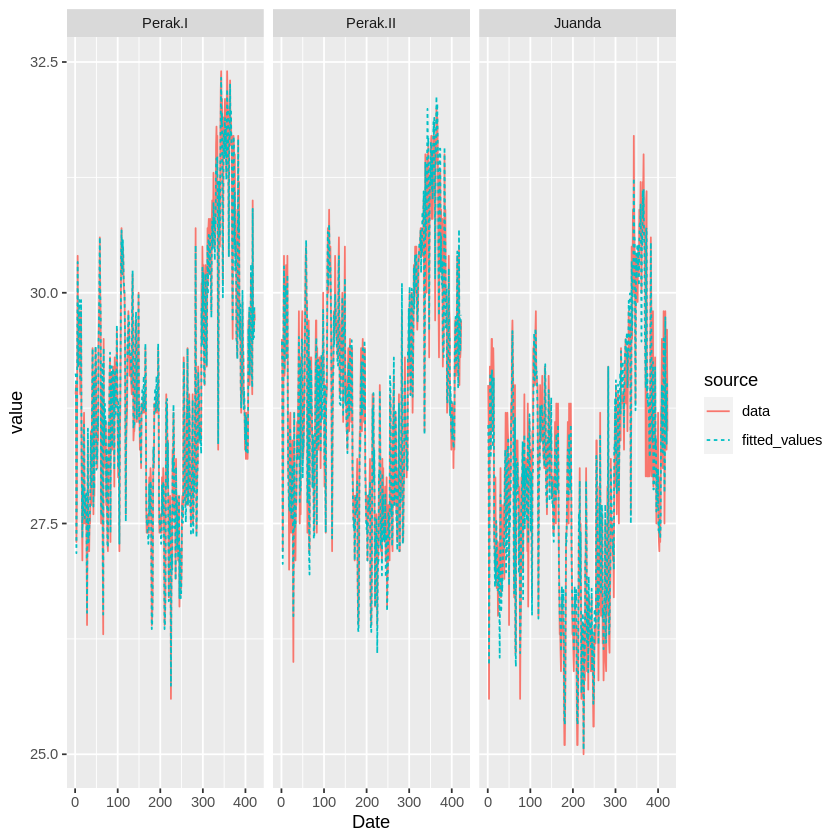

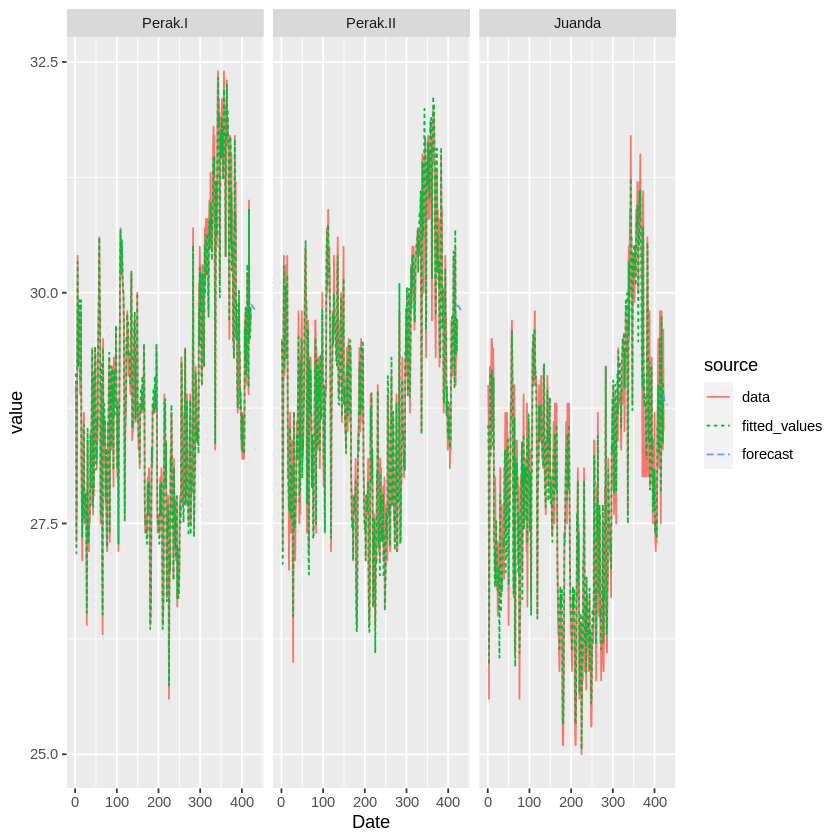

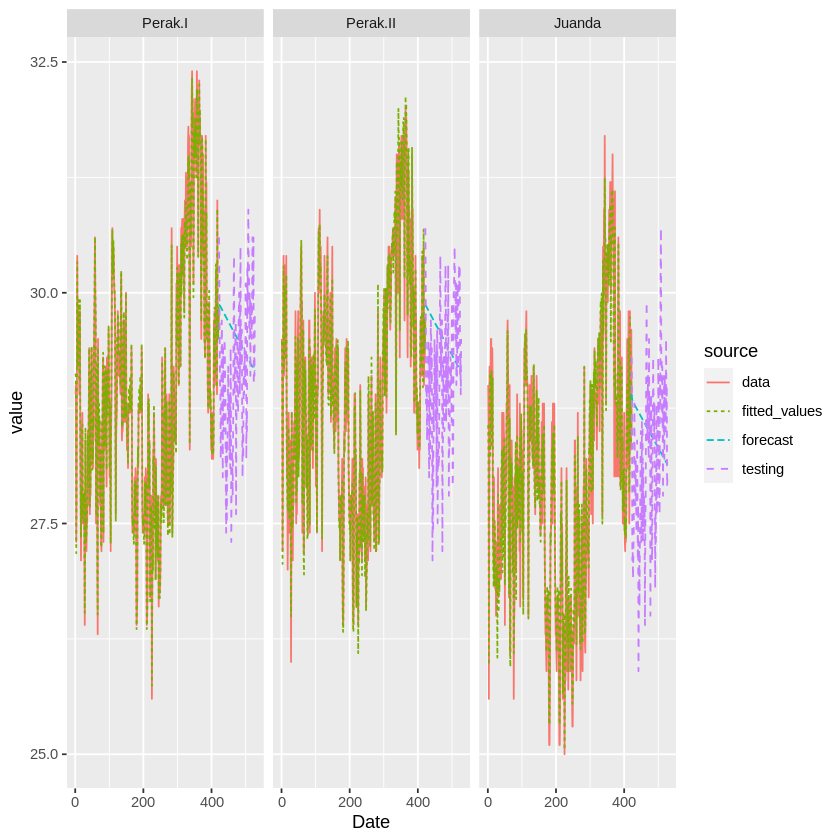

In [22]:
#plot with 10 forecasting data
plot(fit)
plot(fit, n_predict = 10) 
plot(fit, testing = x_test)

### 5.3 Bobot Invers Jarak

In [23]:
#forecast 10 data ahead
predict(fit2, n = 10) 

Perak.I,Perak.II,Juanda
29.70760,29.64885,28.83002
29.69430,29.66885,28.73078
29.68558,29.67201,28.68522
29.67833,29.66891,28.66215
29.67152,29.66349,28.64856
29.66482,29.65723,28.63902
29.65813,29.65067,28.63120
29.65143,29.64400,28.62413
29.64472,29.63730,28.61739
29.63801,29.63059,28.61079


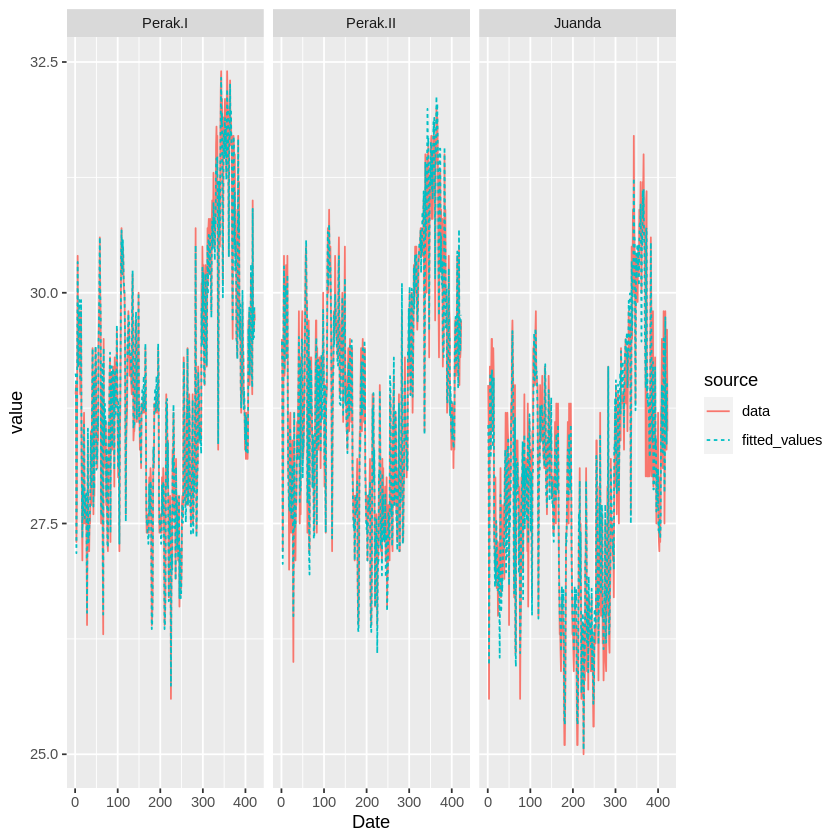

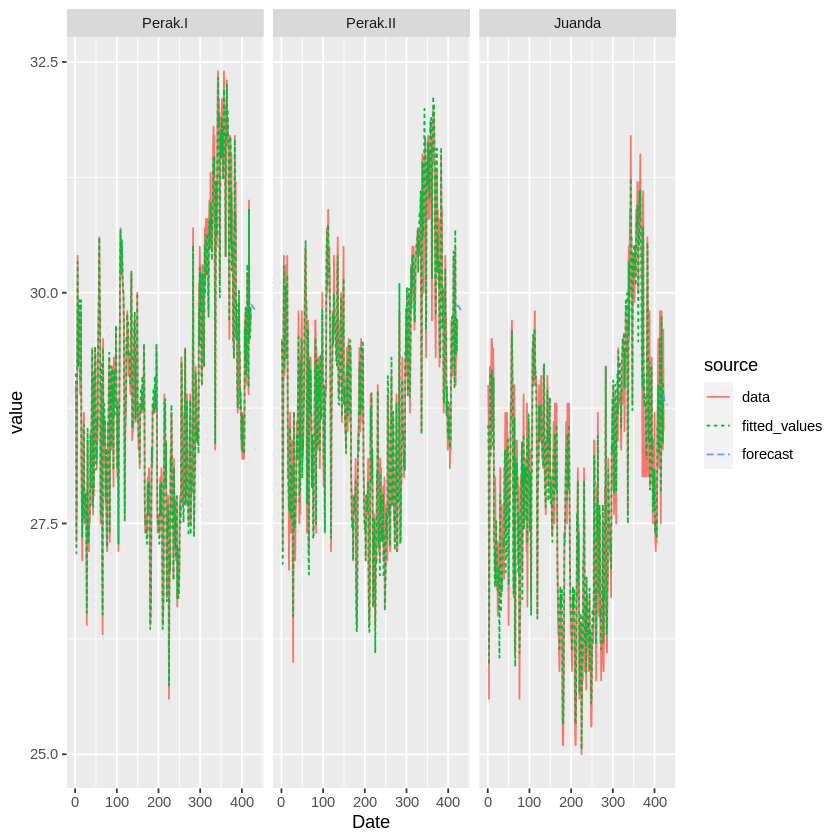

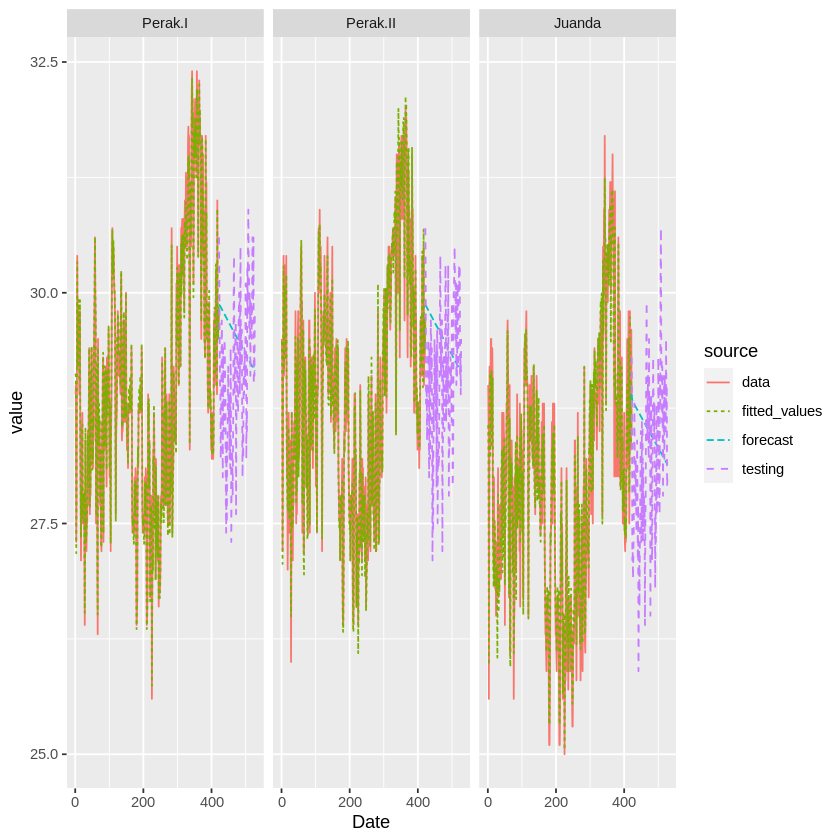

In [24]:
#plot with 10 forecasting data
plot(fit)
plot(fit, n_predict = 10) 
plot(fit, testing = x_test)